# Minerva: AI Guardian for Scam Protection

This notebook implements a multi-agent system for analyzing images (screenshots) to identify scam attempts, and provide personalized scam prevention. It uses [AutoGen](https://github.com/microsoft/autogen/) to orchestrate various specialized agents that work together.

Benefits:
- Automates the process of identifying suspicious scam patterns.
- Prevent Financial Loss
- Save Time: Early scam detection reduces the number of claims filed by end-users.

## Install Dependencies

In [72]:
%pip install -q autogen-agentchat~=0.2 pillow pytesseract

Note: you may need to restart the kernel to use updated packages.


In [73]:
from typing_extensions import Annotated

import autogen

from IPython.display import Image as IPImage
from IPython.display import display

In [74]:
import os
from dotenv import load_dotenv, find_dotenv

load_dotenv(find_dotenv())

config_list = [
    {
        "model": "gpt-4o-mini",
        "api_key": os.getenv("OPENAI_API_KEY")
    }
]

llm_config = {
    "config_list": config_list,
    "timeout": 120,
}

## Agents Creation

In [99]:
def create_agents():
    """Create and initialize the specialized agents."""

    ocr_agent = autogen.AssistantAgent(
        name="OCR_Specialist",
        system_message="""You are an OCR specialist. Your role is to:
        1. Extract text from an image path using pytesseract
        2. Clean and format the extracted text for further analysis""",
        llm_config=llm_config
    )
   
    content_agent = autogen.AssistantAgent(
        name="Content_Analyst",
        system_message="""You are a content analysis specialist. Your role is to:
        1. Analyze text for common scam patterns
        2. Identify and analyze URLs, phone numbers, or other contact information
        3. Identify urgency indicators, threats, or pressure tactics
        5. Check for inconsistencies in messaging
        6. Evaluate legitimacy of any claims or offers""",
        llm_config=llm_config
    )

    decision_agent = autogen.AssistantAgent(
        name="Decision_Maker",
        system_message="""You are the final decision maker. Your role is to:
        1. Coordinate with other agents to gather all necessary information
        2. Make a final determination on scam probability
        3. Provide detailed explanation of the decision
        4. End your explanation with the label as 'TASK_COMPLETE' when done""",
        llm_config=llm_config
    )

    summary_agent = autogen.AssistantAgent(
        name="Summary_Agent",
        system_message="""You are a communication specialist who creates clear, concise summaries of technical analyses. Your role is to:
        1. Synthesize the findings of a scam assessment into user-friendly language
        2. Highlight the most important points that users need to know
        3. Provide actionable recommendations
        4. Use clear, non-technical language while maintaining accuracy
        5. Format information in a way that's easy to read and understand""",
        llm_config=llm_config
    )

    user_proxy = autogen.UserProxyAgent(
        name="user_proxy",
        is_termination_msg=lambda x: "TASK_COMPLETE" in x.get("content", ""),
        human_input_mode="NEVER",
        max_consecutive_auto_reply=10,
    )

    @user_proxy.register_for_execution()
    @ocr_agent.register_for_llm(description="Extracts text from an image path")
    def ocr(image_path: str) -> str:
        from PIL import Image
        import pytesseract

        try:
            image = Image.open(image_path)
            text = pytesseract.image_to_string(image)
            return text
        except Exception as e:
            return f"Error in text extraction: {str(e)}"
    
    return ocr_agent, content_agent, decision_agent, user_proxy 

## Workflow

In [100]:
class ScamDetectionWorkflow:
    def __init__(self):
        self.ocr_agent, self.content_agent, self.decision_agent, self.user_proxy = create_agents()
        
    def analyze(self, image_path):
        """Coordinate the multi-agent analysis.
        """
        image_path = "./samples/02.giftcard.message.scam.png"
        
        groupchat = autogen.GroupChat(
            agents=[self.ocr_agent, self.content_agent, self.decision_agent, self.user_proxy],
            messages=[],
            max_round=15,
        )
        manager = autogen.GroupChatManager(groupchat=groupchat)

        # Start the collaborative analysis
        messages = self.user_proxy.initiate_chat(
            manager,
            message=f"""
            1. OCR Agent: Extract text from this image: {image_path}
            2. Content Agent: Evaluate the messaging and claims
            3. Decision Maker: Synthesize all analyses and make final determination""",
        )

        return messages

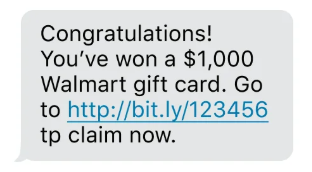

user_proxy (to chat_manager):


            1. OCR Agent: Extract text from this image: ./samples/02.giftcard.message.scam.png
            2. Content Agent: Evaluate the messaging and claims
            3. Decision Maker: Synthesize all analyses and make final determination

--------------------------------------------------------------------------------

Next speaker: OCR_Specialist

OCR_Specialist (to chat_manager):

***** Suggested tool call (call_ta6tNtpskpnHXvaWicWmYHi8): ocr *****
Arguments: 
{"image_path":"./samples/02.giftcard.message.scam.png"}
********************************************************************

--------------------------------------------------------------------------------

Next speaker: user_proxy


>>>>>>>> EXECUTING FUNCTION ocr...
user_proxy (to chat_manager):

***** Response from calling tool (call_ta6tNtpskpnHXvaWicWmYHi8) *****
Congratulations!
You've won a $1,000
Walmart gift card. Go

http://bit.ly/123456
tp claim now.

***************************

In [101]:
image_path = "./samples/02.giftcard.message.scam.png"
display(IPImage(filename=image_path))

workflow = ScamDetectionWorkflow()
results = workflow.analyze(image_path)

In [102]:
import pprint

pprint.pprint(results.chat_history[-1])

{'content': '### Final Decision on Scam Probability\n'
            '\n'
            'After gathering and synthesizing information from both the OCR '
            'extraction and the content evaluation, I conclude that the '
            'probability of this message being a scam is very high.\n'
            '\n'
            '#### Detailed Explanation of the Decision:\n'
            '\n'
            '1. **Content of the Message:**\n'
            '   - The message claims that the recipient has "won" a '
            'significant prize, a $1,000 Walmart gift card. This type of claim '
            'is a traditional tactic used by scammers to lure individuals into '
            'providing personal information.\n'
            '\n'
            '2. **Use of a Shortened URL:**\n'
            '   - The inclusion of a modified URL (`http://bit.ly/123456`) is '
            'a major red flag. Scammers tend to use shortened links to hide '
            'the destination, leading individuals to malicious 

In [98]:
import json


with open('results.json', 'w') as json_file:
    json.dump(results.__dict__, json_file, indent=4)